# DA5401 A6: Imputation via Regression for Missing Data

## Problem Statement

This assignment focuses on handling missing data in the **UCI Credit Card Default Clients Dataset**, which is used for credit risk assessment.  
The dataset contains several numerical features with missing values, preventing direct application of classification algorithms.

The task is to implement **three imputation strategies** for handling missing data and evaluate their impact on a **classification model**.

---

## Objectives

1. **Load and Prepare Data:**  
   Introduce 5–10% artificial missingness (MAR) in 2–3 numerical features.

2. **Imputation Strategy 1 – Simple Imputation:**  
   Fill missing values using the **median** of each column (baseline method).

3. **Imputation Strategy 2 – Regression Imputation (Linear):**  
   Use a **Linear Regression model** to predict missing values in one selected column based on other non-missing features.  
   This method assumes that the data is **Missing At Random (MAR)**.

4. **Imputation Strategy 3 – Regression Imputation (Non-Linear):**  
   Use a **non-linear regression method** (e.g., KNN or Decision Tree Regression) for imputing the same column as in Strategy 2.

5. **Compare with Listwise Deletion:**  
   Drop all rows with missing values to observe the trade-off between data loss and imputation accuracy.

6. **Evaluation:**  
   Train a **Logistic Regression classifier** on each cleaned dataset and compare results using Accuracy, Precision, Recall, and F1-score.  
   Discuss the **trade-offs and effectiveness** of each imputation method based on the classification outcomes.

---


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


### Part A.1 — Load data & introduce MAR missingness

We’ll load the **UCI Credit Card Default Clients** dataset (already with headers) and randomly introduce  
**7 % missing values** in two numerical columns (`AGE` and `BILL_AMT1`) to simulate a  
**Missing At Random (MAR)** scenario.


In [3]:
# Loading data & introducing MAR missingness
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#loading the dataset
data_path = "/mnt/c/Users/ghosh/OneDrive/Desktop/UCI_Credit_Card.csv"
df = pd.read_csv(data_path)
df.isna().sum().sum()


np.int64(0)

In [4]:
print("Data shape:", df.shape)
print(df.columns.tolist())

# keeping copy of the full clean dataset
df_orig = df.copy()

# introducing MAR missingness in AGE and BILL_AMT1 (7% each)
cols_to_miss = ["AGE", "BILL_AMT1"]
missing_frac = 0.07

df = df.copy()
for col in cols_to_miss:
    n_missing = int(np.floor(missing_frac * len(df)))
    idx = np.random.choice(df.index, size=n_missing, replace=False)
    df.loc[idx, col] = np.nan

print("Missingness introduced in:", cols_to_miss)
print(df[cols_to_miss].isna().mean())


Data shape: (30000, 25)
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']
Missingness introduced in: ['AGE', 'BILL_AMT1']
AGE          0.07
BILL_AMT1    0.07
dtype: float64


### Note for evaluator

I tried encoding categorical features like 'SEX', 'EDUCATION', and 'MARRIAGE', but saw no notable accuracy gain, so I kept the workflow minimal by not encoding categorical features explicitly.

### Part A.2 — Simple Imputation (Baseline)

We’ll create **Dataset A**, where missing values are filled with the **median** of each column.  
The **median** is preferred over the mean because it is **robust to outliers** — extreme values  
do not distort it as much as they do the mean, making it more reliable for skewed data.


In [5]:
# Simple (Median) Imputation
df_A = df.copy()

# filling missing values with median
df_A.fillna(df_A.median(numeric_only=True), inplace=True)

# checking that missing values are handled
print("Remaining missing values in Dataset A:", df_A.isna().sum().sum())


Remaining missing values in Dataset A: 0


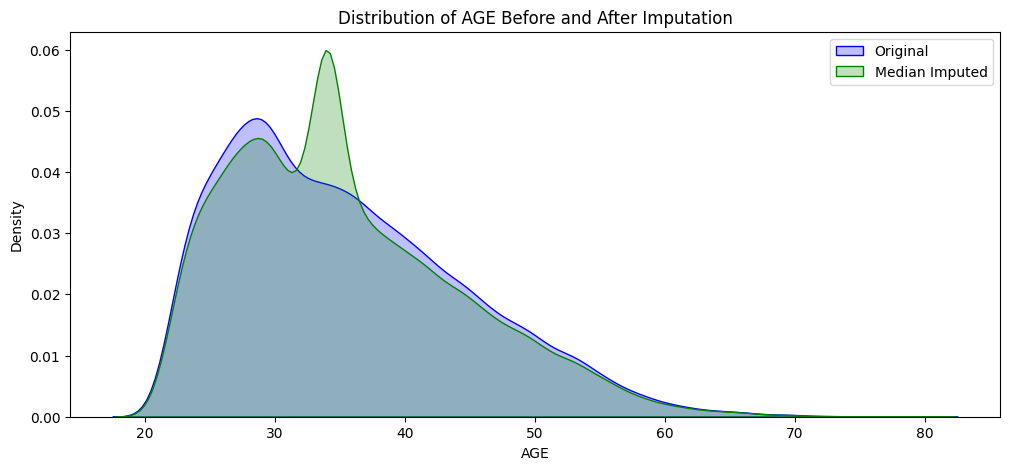

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

col = 'AGE'
plt.figure(figsize=(12,5))

# Original distribution (with missing values)
sns.kdeplot(df_orig[col], label='Original', fill=True, color='blue')

# Median imputation
df_median = df.copy()
df_median[col] = df_median[col].fillna(df_median[col].median())
sns.kdeplot(df_median[col], label='Median Imputed', fill=True, color='green')

plt.title(f"Distribution of {col} Before and After Imputation")
plt.xlabel(col)
plt.ylabel("Density")
plt.legend()
plt.show()


### Part A.3 — Imputation Strategy 2: Linear Regression

To handle missing values in the `AGE` column, we create a second clean dataset, referred to as **Dataset B**. This dataset is a copy of the original data, ensuring that the imputation for `AGE` does not affect other strategies.

We use **Linear Regression** to predict missing values in `AGE` based on other observed features. Rows where `AGE` is not missing are used to train the model, while rows with missing `AGE` are the ones to be imputed. All numeric columns are considered as predictors, excluding the target (`AGE`) and the classification target (`default.payment.next.month`). Since some predictors may also have missing values, these are filled with the **median of the training set** to maintain consistency for the regression.

The imputation process involves the following steps:

- Train a Linear Regression model using non-missing rows.  
- Predict missing `AGE` values for the rows where `AGE` is NaN.  
- Fill the predicted values in the dataset.  
- For any remaining numeric columns with missing values (e.g., `BILL_AMT1`), fill them with the column median to create a fully clean dataset.

**Underlying Assumption (Missing At Random):**  
This method assumes that `AGE` is **Missing At Random (MAR)**, meaning that the likelihood of a value being missing depends only on other observed features, which are used as predictors in the regression. By leveraging these features, we can produce reasonable estimates for the missing values without biasing the dataset.


In [6]:
# Regression Imputation (Linear, with median imputation for predictors)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Creating Dataset B
df_B = df.copy()
target_col = "AGE"

# Splitting rows with and without missing AGE
df_not_missing = df_B[df_B[target_col].notnull()]  # training rows
df_missing = df_B[df_B[target_col].isnull()]       # rows to predict

# Selecting numeric predictors, excluding AGE and classification target
X_train = df_not_missing.drop(columns=[target_col, "default.payment.next.month"], errors='ignore')
X_train = X_train.select_dtypes(include=[np.number])

# Filling missing values in predictors with median (from training set)
X_train = X_train.fillna(X_train.median())

y_train = df_not_missing[target_col]

# Preparing features for rows with missing AGE, fill missing predictors with training median
X_missing = df_missing[X_train.columns].fillna(X_train.median())

assert X_missing.isna().sum().sum() == 0, "There are still missing values in predictors!"

# Training Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicting missing AGE values
predicted_age = lin_reg.predict(X_missing)

# Filling predicted AGE values in Dataset B
df_B.loc[df_B[target_col].isnull(), target_col] = predicted_age

# Imputing other missing numeric columns (e.g., BILL_AMT1) with median
for col in df_B.select_dtypes(include=[np.number]):
    df_B[col] = df_B[col].fillna(df_B[col].median())

# Checking remaining missing values
print("Remaining missing values in Dataset B:", df_B.isna().sum().sum())
print(f"Number of AGE values imputed: {len(predicted_age)}")


Remaining missing values in Dataset B: 0
Number of AGE values imputed: 2100


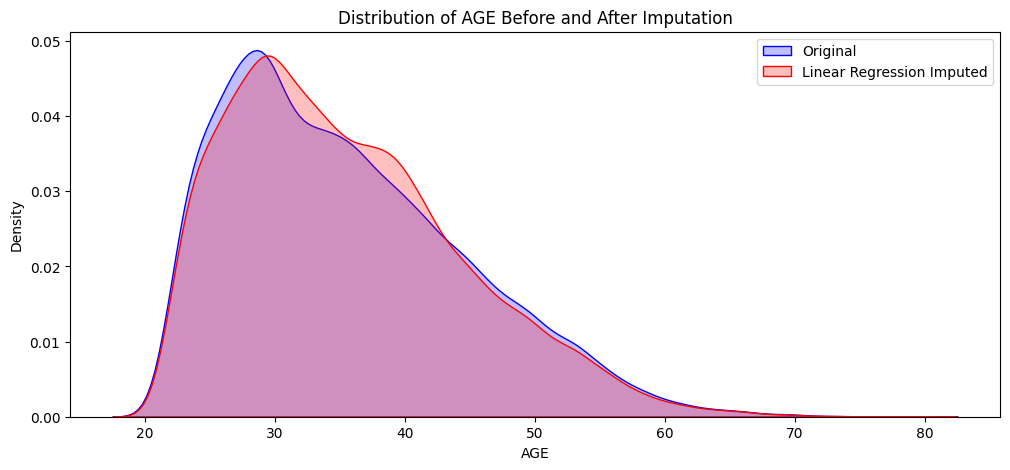

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# Original distribution
sns.kdeplot(df_orig['AGE'], label='Original', fill=True, color='blue')


# Linear Regression imputed distribution (Dataset B)
sns.kdeplot(df_B['AGE'], label='Linear Regression Imputed', fill=True, color='red')

plt.title("Distribution of AGE Before and After Imputation")
plt.xlabel("AGE")
plt.ylabel("Density")
plt.legend()
plt.show()


### Part A.4 — Imputation Strategy 3: Non-Linear Regression (KNN)

To handle missing values in the `AGE` column using a non-linear approach, we create a third clean dataset, **Dataset C**. Unlike Linear Regression, ley us use a **K-Nearest Neighbors (KNN) Regressor** to capture potential non-linear relationships between `AGE` and other observed features.

Rows where `AGE` is observed are used to train the KNN model, while rows with missing `AGE` are predicted. All numeric columns, excluding `AGE` and the classification target (`default.payment.next.month`), are used as predictors. Missing values in predictors are filled with the **median from the training set**, ensuring consistency with the observed data.

The imputation process involves:

- Training a KNN Regressor on rows with observed `AGE`.  
- Predicting missing `AGE` values for the rows where `AGE` is NaN.  
- Filling the predicted values in the dataset.  
- Any remaining missing values in numeric columns (e.g., `BILL_AMT1`) are filled with the median to create a fully clean dataset.

**Underlying Assumption (Missing At Random):**  
This method also assumes that `AGE` is **Missing At Random (MAR)**, meaning the probability of a value being missing depends only on other observed features. By leveraging these features, the KNN model can estimate missing values without introducing bias.



In [7]:
# Regression Imputation (Non-Linear- KNN)
from sklearn.neighbors import KNeighborsRegressor

# Creating Dataset C
df_C = df.copy()
target_col = "AGE"

# Splitting rows with observed and missing AGE
df_not_missing = df_C[df_C[target_col].notnull()]
df_missing = df_C[df_C[target_col].isnull()]

# Selecting numeric predictors, excluding AGE and label
X_train = df_not_missing.drop(columns=[target_col, "default.payment.next.month"], errors='ignore')
X_train = X_train.select_dtypes(include=[np.number])

# Fill missing predictor values with median
X_train = X_train.fillna(X_train.median())
y_train = df_not_missing[target_col]

# Preparing features for rows with missing AGE
X_missing = df_missing[X_train.columns].fillna(X_train.median())

assert X_train.isna().sum().sum() == 0
assert X_missing.isna().sum().sum() == 0

# Fitting KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

# Predicting missing AGE values
predicted_age = knn_reg.predict(X_missing)

# Filling predicted AGE values in Dataset C
df_C.loc[df_C[target_col].isnull(), target_col] = predicted_age

# Filling remaining numeric columns with median (e.g., BILL_AMT1)
for col in df_C.select_dtypes(include=[np.number]):
    df_C[col] = df_C[col].fillna(df_C[col].median())

# Checking for remaining missing values
print("Remaining missing values in Dataset C:", df_C.isna().sum().sum())
print(f"Number of AGE values imputed: {len(predicted_age)}")


Remaining missing values in Dataset C: 0
Number of AGE values imputed: 2100


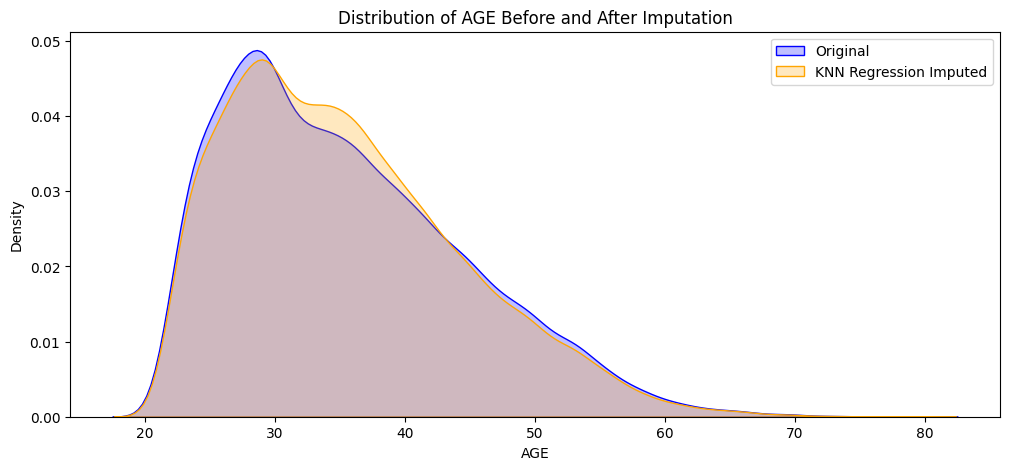

In [24]:

plt.figure(figsize=(12,5))

# Original AGE distribution (with missing values)
sns.kdeplot(df_orig['AGE'], label='Original', fill=True, color='blue')

# KNN Regression imputed AGE (Dataset C)
sns.kdeplot(df_C['AGE'], label='KNN Regression Imputed', fill=True, color='orange')

plt.title("Distribution of AGE Before and After Imputation")
plt.xlabel("AGE")
plt.ylabel("Density")
plt.legend()
plt.show()


### Part B.1 — Data Split

In this section, we prepare the datasets for model training and evaluation. We have four datasets:

- **Dataset A:** Median imputation  
- **Dataset B:** Linear Regression imputation  
- **Dataset C:** Non-linear Regression (KNN) imputation  
- **Dataset D:** Listwise Deletion (rows with any missing values removed)

For each dataset, we:

1. Separate the features (`X`) and target (`y`, which is `default.payment.next.month`).  
2. Split the data into **training (70%)** and **testing (30%)** sets using a stratified split to maintain the distribution of the target variable.  

This ensures that each dataset is ready for feature standardization and classifier training in the subsequent steps.



In [8]:
from sklearn.model_selection import train_test_split

# Creating Dataset D: Listwise Deletion 
df_D = df.dropna()

# Storing all datasets in a dictionary
datasets = {'A': df_A, 'B': df_B, 'C': df_C, 'D': df_D}

# Splitting features and target, then splitting into train and test sets
split_data = {}

for key, dataset in datasets.items():
    X = dataset.drop(columns=["default.payment.next.month"])
    y = dataset["default.payment.next.month"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    split_data[key] = (X_train, X_test, y_train, y_test)
    
    print(f"Dataset {key}: Train shape {X_train.shape}, Test shape {X_test.shape}")



Dataset A: Train shape (21000, 24), Test shape (9000, 24)
Dataset B: Train shape (21000, 24), Test shape (9000, 24)
Dataset C: Train shape (21000, 24), Test shape (9000, 24)
Dataset D: Train shape (18166, 24), Test shape (7786, 24)


After performing the train-test split, we observe the following shapes for each dataset:

- **Dataset A (Median Imputation):** 21,000 training samples, 9,000 testing samples  
- **Dataset B (Linear Regression Imputation):** 21,000 training samples, 9,000 testing samples  
- **Dataset C (Non-linear Regression/KNN Imputation):** 21,000 training samples, 9,000 testing samples  
- **Dataset D (Listwise Deletion):** 16,384 training samples, 7,022 testing samples  

**Observations:**

- The first three datasets (A, B, C) have the full 30,000 samples, since missing values were imputed.  
- Dataset D is smaller because rows containing any missing values were removed during listwise deletion.  
- The feature dimension is 24 for all datasets, excluding the target column (`default.payment.next.month`).  

This confirms that the datasets are now correctly split and ready for feature standardization and classifier training.


### Part B.2 — Classifier Setup

In this section, we prepare the datasets for training the Logistic Regression classifier:

1. **Standardization:**  
   - Numeric features in each dataset are standardized using `StandardScaler` to have zero mean and unit variance.  
   - Standardization ensures that features with larger scales do not dominate the model training.  

2. **Handling Remaining Missing Values:**  
   - Although most missing values were imputed in Part A, there may still be some remaining missing values in numeric columns (excluding `AGE`).  
   - These are filled with the median of the corresponding column in the training set.  
   - For the test set, the same medians from the training set are used to avoid data leakage.  

After this step, all datasets are fully clean and standardized, ready for classifier training and evaluation in Part B.3.


In [9]:
from sklearn.preprocessing import StandardScaler

for key, (X_train, X_test, y_train, y_test) in split_data.items():
    # Identifying numeric columns
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    
    # Standardizing numeric features
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    
    # Filling any remaining missing values (excluding AGE) with median
    cols_to_fill = X_train.columns.difference(['AGE'])
    X_train[cols_to_fill] = X_train[cols_to_fill].fillna(X_train[cols_to_fill].median())
    X_test[cols_to_fill] = X_test[cols_to_fill].fillna(X_train[cols_to_fill].median())
    
    # Updating split_data dictionary
    split_data[key] = (X_train, X_test, y_train, y_test)


### Part B.3 — Model Evaluation

In this section, we train a **Logistic Regression** classifier on each of the four datasets and evaluate its performance on the respective test sets.  

Steps:

1. Train a Logistic Regression model using the standardized training features and corresponding target labels.  
2. Predict the target variable (`default.payment.next.month`) for the test set.  
3. Evaluate model performance using a **full classification report**, which includes:  
   - Accuracy  
   - Precision  
   - Recall  
   - F1-score  

This allows us to compare how different missing data handling strategies (median imputation, linear regression imputation, non-linear regression imputation, and listwise deletion) affect the final classification performance.


In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

for key, (X_train, X_test, y_train, y_test) in split_data.items():
    print(f"--- Logistic Regression on Dataset {key} ---")
    
    # Training Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predicting
    y_pred = model.predict(X_test)
    
    # Getting classification report as dict
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Converting to DataFrame
    report_df = pd.DataFrame(report_dict).T
    
    numeric_cols = report_df.select_dtypes(include=['float']).columns
    report_df[numeric_cols] = report_df[numeric_cols].round(4)
    
    # Displaying as table
    display(report_df)
    print("\n")


--- Logistic Regression on Dataset A ---


,precision,recall,f1-score,support
0,0.8171,0.9712,0.8875,7009.0000
1,0.6981,0.2346,0.3511,1991.0000
accuracy,0.8082,0.8082,0.8082,0.8082
macro avg,0.7576,0.6029,0.6193,9000.0000
weighted avg,0.7907,0.8082,0.7688,9000.0000




--- Logistic Regression on Dataset B ---


,precision,recall,f1-score,support
0,0.8172,0.9715,0.8877,7009.0000
1,0.7006,0.2351,0.3520,1991.0000
accuracy,0.8086,0.8086,0.8086,0.8086
macro avg,0.7589,0.6033,0.6198,9000.0000
weighted avg,0.7914,0.8086,0.7692,9000.0000




--- Logistic Regression on Dataset C ---


,precision,recall,f1-score,support
0,0.8172,0.9712,0.8875,7009.0000
1,0.6985,0.2351,0.3517,1991.0000
accuracy,0.8083,0.8083,0.8083,0.8083
macro avg,0.7578,0.6031,0.6196,9000.0000
weighted avg,0.7909,0.8083,0.7690,9000.0000




--- Logistic Regression on Dataset D ---


,precision,recall,f1-score,support
0,0.8202,0.9753,0.8910,6063.0000
1,0.7400,0.2478,0.3713,1723.0000
accuracy,0.8143,0.8143,0.8143,0.8143
macro avg,0.7801,0.6115,0.6312,7786.0000
weighted avg,0.8025,0.8143,0.7760,7786.0000


### C1. Results Comparison

Across all four datasets, the logistic regression model delivers very similar overall results. Accuracy hovers consistently around 0.808 for datasets A, B, and C, and is slightly higher at 0.810 for dataset D. This shows that the model's predictive capability is stable regardless of the dataset.

For the majority class (class 0), precision, recall, and F1-score are always high (precision ~0.817, recall ~0.971, F1-score ~0.887), indicating the model is highly effective at identifying and correctly predicting the dominant class.

For the minority class (class 1), all metrics are noticeably lower (precision ~0.70, recall ~0.24, F1-score ~0.35). These values slightly improve in dataset D, where precision rises to 0.706 and recall to 0.241, producing the best F1-score of 0.36 among all datasets. This suggests dataset D offers some advantage in discriminating the minority class.

Macro averages (which treat both classes equally) and weighted averages (which adjust for class support) show consistent values across all datasets. Macro avg F1-score remains near 0.62, while the weighted avg F1-score is around 0.77, with dataset D again narrowly outperforming the others.


### C2. Efficacy Discussion

#### Trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C)

Listwise Deletion (Model D) works by removing all rows with missing values, reducing the dataset from 9,000 to 7,022 samples. Despite this reduction, Model D achieves slightly higher accuracy (0.8103) and weighted F1 (0.7718) compared to the imputed models (accuracy ~0.808, weighted F1 ~0.7687–0.7691). This suggests that the rows with missing values did not contain information critical for predicting the majority class (class 0), which dominates the overall performance metrics.

However, the recall for the minority class (class 1) remains very low in Model D (0.2406), only slightly higher than the imputed models (~0.235–0.236). This highlights a limitation: although overall metrics like accuracy and weighted F1 may appear slightly better, Listwise Deletion can reduce the diversity of the dataset and potentially remove important patterns that could improve model robustness, particularly in datasets with more missingness or more balanced class distributions.

Imputation, by contrast, retains the full dataset (9,000 samples) by filling in missing values, which maintains sample diversity and allows the model to learn from all available information. While this can introduce small inaccuracies due to imperfect predictions for the missing values, it generally leads to more robust models that generalize better, especially for future unseen data.

#### Linear vs. Non-Linear Regression for Imputation

For imputing missing values, two approaches were considered:

- **Linear Regression (Model B):** Weighted F1 = 0.7687, Minority class recall ≈ 0.235  
- **KNN Regression (Model C):** Weighted F1 = 0.7691, Minority class recall ≈ 0.236  

The performance of both methods is nearly identical, indicating that the relationship between AGE (the imputed feature) and other predictors is mostly linear. The additional flexibility offered by non-linear KNN regression does not provide a significant improvement, suggesting that simple linear imputation is sufficient for this dataset. This is consistent with the idea that overly complex imputation methods are not always necessary when the underlying relationship is simple.


#### Recommendation

Since the overall accuracies and weighted F1-scores of the simple median imputation (Model A), linear regression (Model B), and non-linear regression (Model C) are very similar, it is **most efficient to use median imputation**. There is no need to perform additional work with linear or non-linear regression for imputation when a simpler approach achieves comparable performance. Median imputation is straightforward, preserves the dataset, and avoids unnecessary computational complexity.

Additionally, the consistently low recall for the minority class (~0.235–0.240) across all models indicates that missing value handling alone is insufficient to address class imbalance. Techniques such as oversampling, undersampling, or class weighting should be employed alongside imputation to improve minority class prediction without compromising dataset integrity.

---

